---
title: "weight data"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---


Now that we have height data covered, it's time we deal with weight data.

Yes, I am **VERY WELL AWARE** that weight is a force, and it is not measured in kg. Nevertheless, I will use the word weight in the colloquial sense, and for all purposes it is a synonym for mass.

This analysis will follow the same steps we used for height data, therefore I will skip some of the intermediate steps. Whenever there are differences, I will point them out.

In [1]:
#| code-summary: "import libraries"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.interpolate import UnivariateSpline
import matplotlib.animation as animation
from scipy.stats import norm
from scipy.stats import lognorm
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'
%matplotlib widget

In [2]:
#| code-summary: "define useful arrays"
age_list = np.round(np.arange(2.0, 20.1, 0.1), 1)
weight_list = np.round(np.arange(10, 100, 0.1), 1)

We will load all the digitized data for the weight curves, and will interpolate.

In [3]:
#| code-summary: "interpolate all growth curves"
col_names = ['p05', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95']
file_names_boys = ['boys-p05.csv', 'boys-p10.csv', 'boys-p25.csv', 'boys-p50.csv',
                   'boys-p75.csv', 'boys-p90.csv', 'boys-p95.csv',]
file_names_girls = ['girls-p05.csv', 'girls-p10.csv', 'girls-p25.csv', 'girls-p50.csv',
                   'girls-p75.csv', 'girls-p90.csv', 'girls-p95.csv',]

# create dataframe with age column
df_boys = pd.DataFrame({'age': age_list})
df_girls = pd.DataFrame({'age': age_list})
# loop over file names and read in data
for i, file_name in enumerate(file_names_boys):
    # read in data
    df_temp = pd.read_csv('../archive/data/weight/' + file_name, names=['age','weight'])
    spline = UnivariateSpline(df_temp['age'], df_temp['weight'], s=0.5)
    df_boys[col_names[i]] = spline(age_list)
for i, file_name in enumerate(file_names_girls):
    # read in data
    df_temp = pd.read_csv('../archive/data/weight/' + file_name, names=['age','weight'])
    spline = UnivariateSpline(df_temp['age'], df_temp['weight'], s=0.5)
    df_girls[col_names[i]] = spline(age_list)

# make age index
df_boys.set_index('age', inplace=True)
df_boys.index = df_boys.index.round(1)
df_boys.to_csv('../archive/data/weight/boys_weight_vs_age_combined.csv', index=True)
df_girls.set_index('age', inplace=True)
df_girls.index = df_girls.index.round(1)
df_girls.to_csv('../archive/data/weight/girls_weight_vs_age_combined.csv', index=True)

Let's see now the results:

In [4]:
#| code-summary: "show dataframe for girls"
#| code-fold: false
df_girls

,p05,p10,p25,p50,p75,p90,p95
age,,,,,,,
2.0,10.169139,10.527385,11.117607,12.111512,12.934594,13.970137,14.662625
2.1,10.312243,10.674421,11.291813,12.276811,13.155592,14.191386,14.907424
2.2,10.455176,10.821547,11.465113,12.443392,13.376209,14.415799,15.155615
2.3,10.597984,10.968806,11.637596,12.611299,13.596546,14.643380,15.407214
2.4,10.740711,11.116243,11.809350,12.780573,13.816707,14.874137,15.662236
...,...,...,...,...,...,...,...
19.6,46.015792,48.041956,52.097485,57.744985,65.357860,74.916720,82.545975
19.7,46.008755,48.085732,52.168559,57.855278,65.511084,75.011896,82.648322
19.8,45.997560,48.129771,52.240501,57.969161,65.669232,75.094395,82.748961


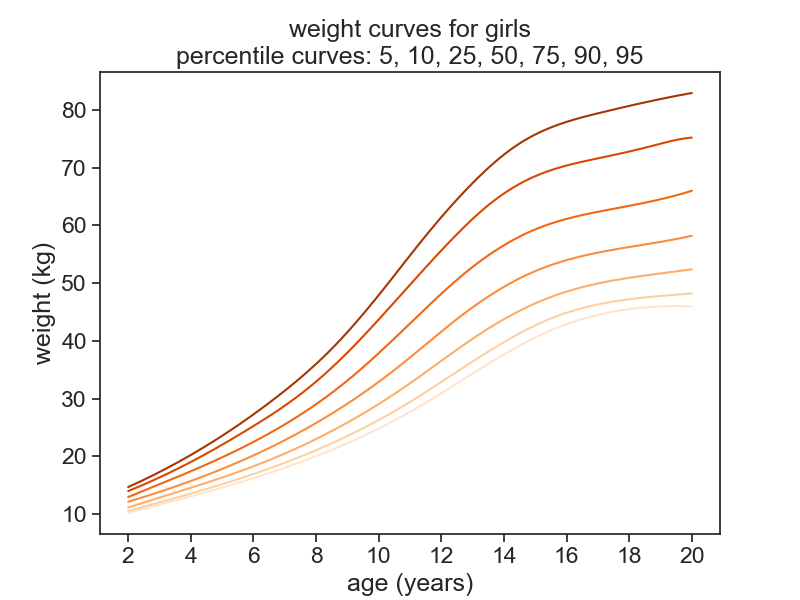

In [5]:
#| code-summary: "show all interpolated curves for girls"
fig, ax = plt.subplots(figsize=(8, 6))
# loop over col_names and plot each column
colors = sns.color_palette("Oranges", len(col_names))
for col, color in zip(col_names, colors):
    ax.plot(df_girls.index, df_girls[col], label=col, color=color)
ax.set(xlabel='age (years)',
       ylabel='weight (kg)',
       xticks=np.arange(2, 21, 2),
       title="weight curves for girls\npercentile curves: 5, 10, 25, 50, 75, 90, 95",
       );

Let's now see the percentiles for girls age 20.

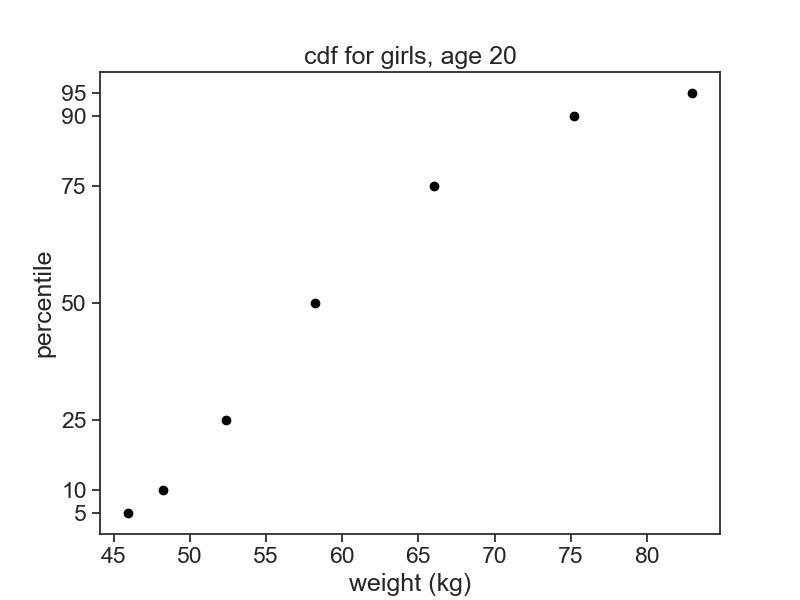

In [6]:
#| code-summary: "plot cdf for girls, age 20"
fig, ax = plt.subplots(figsize=(8, 6))
percentile_list = np.array([5, 10, 25, 50, 75, 90, 95])
data = df_girls.loc[20.0]
ax.plot(data, percentile_list, ls='', marker='o', markersize=6, color="black")
ax.set(xlabel='weight (kg)',
         ylabel='percentile',
         yticks=percentile_list,
         title="cdf for girls, age 20"
         );

This time, I am not so sure that a normal (gaussian) distribution is a good fit for the data. I check if a log-normal distribution does the job.

In [74]:
#| code-summary: "define functions"
def erf_model(x, mu, sigma):
    return 50 * (1 + erf((x - mu) / (sigma * np.sqrt(2))) )
def erf_lognormal_model(x, mu, sigma):
    return 50 * (1 + erf((np.log(x) - mu) / (sigma * np.sqrt(2))) )
def cdf_lognormal(x, mu, sigma):
    return 100*lognorm.cdf(x, s=sigma, scale=mu)
def cdf_gamma(x, a, b):
    return 100*gamma.cdf(x, a=a, scale=b)
# initial guess for parameters: [mu, sigma]
p0 = np.array([50, 3])
p0_ln = np.array([50, 0.2])
# Calculate R-squared
def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

In [105]:
#| code-summary: "fit model to data"
data = df_girls.loc[20.0]
params, _ = curve_fit(erf_model, data, percentile_list, p0=p0,
                        bounds=([10, 1],   # lower bounds for mu and sigma
                                [100, 20])  # upper bounds for mu and sigma
                        )
params2, _ = curve_fit(erf_model, np.log(data), percentile_list, p0=np.log(p0),
                        bounds=([np.log(10), 0],   # lower bounds for mu and sigma
                                [np.log(100), np.log(20)])  # upper bounds for mu and sigma
                        )
params3, _ = curve_fit(cdf_lognormal, data, percentile_list, p0=p0_ln,
                        bounds=([10, 0.05],   # lower bounds for mu and sigma
                                [100, 1.00])  # upper bounds for mu and sigma
                        )
p0_gamma = np.array([50, 0.9])
params4, _ = curve_fit(cdf_gamma, data, percentile_list, p0=p0_gamma,
                        bounds=([30, 0.5],   # lower bounds for mu and sigma
                                [80, 1.5])  # upper bounds for mu and sigma
                        )
# store the parameters in the dataframe
percentile_predicted = erf_model(data, *params)
percentile_predicted2 = erf_model(np.log(data), *params2)
percentile_predicted3 = cdf_lognormal(data, *params3)
percentile_predicted4 = cdf_gamma(data, *params4)


# R-squared value
r2 = calculate_r2(percentile_list, percentile_predicted)
r2b = calculate_r2(percentile_list, percentile_predicted2)
r2c = calculate_r2(percentile_list, percentile_predicted3)
r2d = calculate_r2(percentile_list, percentile_predicted4)

In [79]:
params4, r2d

(array([38.66428713,  1.46253451]), 0.9924311256135725)

In [61]:
params3, r2c, percentile_predicted3

(array([55.95300497,  0.16283376]),
 0.9944470433169026,
 array([ 7.97666653, 12.25680131, 24.25581653, 47.087817  , 74.72185354,
        93.52040652, 98.42654193]))

In [63]:
from scipy.stats import gamma


In [104]:
percentile_list

array([ 5, 10, 25, 50, 75, 90, 95])

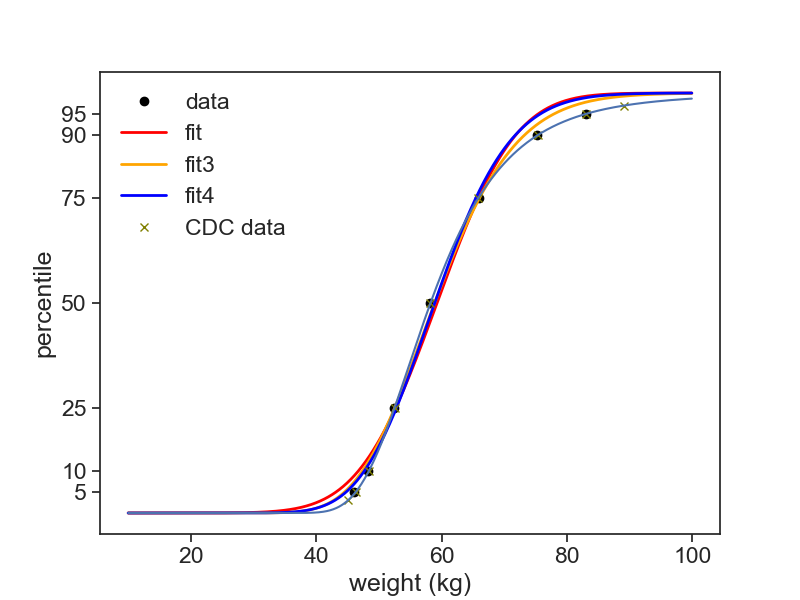

In [130]:
#| code-summary: "show results"
fig, ax = plt.subplots(figsize=(8, 6))
percentile_list = np.array([5, 10, 25, 50, 75, 90, 95])
ax.plot(data, percentile_list, ls='', marker='o', markersize=6, color="black", label='data')
fit = erf_model(weight_list, *params)
# fit2 = np.exp(erf_model(np.log(weight_list), *(np.log(params))))
ax.plot(weight_list, fit, label='fit', color="red", linewidth=2)
# ax.plot(weight_list, 100*lognorm.cdf(weight_list, loc=np.exp(params2[0]), s=1*np.exp(params2[1]) ), label='fit2', color="orange", linewidth=2)
ax.plot(weight_list, 100*lognorm.cdf(weight_list, scale=params3[0], s=params3[1] ), label='fit3', color="orange", linewidth=2)
ax.plot(weight_list, 100*gamma.cdf(weight_list, a=params4[0], scale=params4[1] ), label='fit4', color="blue", linewidth=2)

# ax.plot(weight_list, 100*lognorm.cdf(weight_list, scale=58, s=0.18 ), label='fit2', color="orange", linewidth=2)
# ax.text(150, 75, f'$\mu$ = {params[0]:.1f} cm\n$\sigma$ = {params[1]:.1f} cm\nR$^2$ = {r2:.6f}',
        # fontsize=14, bbox=dict(facecolor='white', alpha=0.5))



# ax.plot(weight_list, 100*gamma.cdf(weight_list, a=68, scale=0.8), label='gamma', color="blue", linewidth=2)
cdc_percentile = [3, 5, 10, 25, 50, 75, 90, 95, 97]
ax.plot(cdc_vals[0], cdc_percentile, ls='', marker='x', markersize=6, color="olive", label='CDC data')
lms = women.loc[240.0, ['L', 'M', 'S']].values
ax.plot(weight_list, Zscore_to_percentile(cdc_eq(weight_list, *lms)))

ax.legend(frameon=False)
ax.set(xlabel='weight (kg)',
    #    xlim=(140, 190),
         ylabel='percentile',
         yticks=percentile_list,
        #  title="the data is very well fitted by a normal distribution"
         );

In [131]:
https://www.cdc.gov/growthcharts/cdc-data-files.htm

SyntaxError: invalid syntax (1102385488.py, line 1)

In [129]:
def Zscore_to_percentile(z):
    return 100 * norm.cdf(z)

In [111]:
cdc_vals[0], percentile_list

(array([45.04654822, 46.28963394, 48.38346004, 52.47876433, 58.21897289,
        65.85237979, 75.35164989, 82.95375457, 89.04485133]),
 array([ 5, 10, 25, 50, 75, 90, 95]))

In [85]:
df_cdc = pd.read_csv('../archive/data/cdc_wt_age.csv')
df_cdc

,Sex,Agemos,L,M,S,P3,P5,P10,P25,P50,P75,P90,P95,P97
0,1,24.0,-0.206152,12.670763,0.108126,10.382090,10.640090,11.052656,11.785975,12.670763,13.636919,14.583398,15.187773,15.596483
1,1,24.5,-0.216501,12.741544,0.108166,10.441442,10.700513,11.114904,11.851817,12.741544,13.713860,14.667158,15.276296,15.688406
2,1,25.5,-0.239790,12.881023,0.108275,10.558473,10.819575,11.237473,11.981419,12.881023,13.865896,14.833316,15.452424,15.871699
3,1,26.5,-0.266316,13.018424,0.108421,10.673803,10.936812,11.358059,12.108888,13.018424,14.016230,14.998478,15.628189,16.055142
4,1,27.5,-0.295755,13.154497,0.108605,10.787982,11.052801,11.477280,12.234907,13.154497,14.165672,15.163512,15.804500,16.239671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,2,236.5,-1.558179,58.030397,0.165698,45.012603,46.238515,48.304379,52.349208,58.030397,65.612151,75.100412,82.744477,88.906346
432,2,237.5,-1.543846,58.094532,0.165985,45.027517,46.258911,48.333695,52.394603,58.094532,65.692518,75.183669,82.813450,88.951645
433,2,238.5,-1.530642,58.151036,0.166260,45.038521,46.274976,48.357997,52.433762,58.151036,65.764133,75.258306,82.875461,88.992530
434,2,239.5,-1.518754,58.198771,0.166520,45.045100,46.286116,48.376568,52.465761,58.198771,65.825742,75.323211,82.929752,89.028669


In [114]:
def cdc_eq(age, L, M, S):
    if L != 0:
        return ((age/M)**L -1) / (L*S)
    else:
        return np.log(age/M) / S

In [ ]:
# women.set_index('Agemos', inplace=True)


array([-1.51336185, 58.21897289,  0.16664475])

In [96]:
women = df_cdc[df_cdc['Sex']==2]
women240 = women[women['Agemos']==240.0]
# women240
women240

,Sex,Agemos,L,M,S,P3,P5,P10,P25,P50,P75,P90,P95,P97
435,2,240.0,-1.513362,58.218973,0.166645,45.046548,46.289634,48.38346,52.478764,58.218973,65.85238,75.35165,82.953755,89.044851


In [102]:
cols = women240.columns[5:]
cdc_vals = women240.loc[:, cols].values

In [94]:
df_cdc

,Sex,Agemos,L,M,S,P3,P5,P10,P25,P50,P75,P90,P95,P97
0,1,24.0,-0.206152,12.670763,0.108126,10.382090,10.640090,11.052656,11.785975,12.670763,13.636919,14.583398,15.187773,15.596483
1,1,24.5,-0.216501,12.741544,0.108166,10.441442,10.700513,11.114904,11.851817,12.741544,13.713860,14.667158,15.276296,15.688406
2,1,25.5,-0.239790,12.881023,0.108275,10.558473,10.819575,11.237473,11.981419,12.881023,13.865896,14.833316,15.452424,15.871699
3,1,26.5,-0.266316,13.018424,0.108421,10.673803,10.936812,11.358059,12.108888,13.018424,14.016230,14.998478,15.628189,16.055142
4,1,27.5,-0.295755,13.154497,0.108605,10.787982,11.052801,11.477280,12.234907,13.154497,14.165672,15.163512,15.804500,16.239671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,2,236.5,-1.558179,58.030397,0.165698,45.012603,46.238515,48.304379,52.349208,58.030397,65.612151,75.100412,82.744477,88.906346
432,2,237.5,-1.543846,58.094532,0.165985,45.027517,46.258911,48.333695,52.394603,58.094532,65.692518,75.183669,82.813450,88.951645
433,2,238.5,-1.530642,58.151036,0.166260,45.038521,46.274976,48.357997,52.433762,58.151036,65.764133,75.258306,82.875461,88.992530
434,2,239.5,-1.518754,58.198771,0.166520,45.045100,46.286116,48.376568,52.465761,58.198771,65.825742,75.323211,82.929752,89.028669
